### Imports and CUDA

In [2]:
# Matplotlib
import requests
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

In [3]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Objective

#### To develop a model that predicts taxi availability within a specific area for the next three hours. This means that if the model is run at 12 PM, it will provide predicted taxi availability for 1 PM, 2 PM, and 3 PM.

The area of interest is defined by the following geographical boundaries:

    North: 1.35106
    South: 1.32206
    East: 103.97839
    West: 103.92805

To identify the taxis currently available within this region, we use the TaxiAvailabilityScript.py.

This script collects real-time data, which serves as input for our predictive model.

By leveraging historical taxi availability trends and real-time data, our model aims to provide accurate forecasts, helping commuters, ride-hailing services, and urban planners make informed decisions.


# **To-Do List for Taxi Availability Prediction**

## **Step 1: Cleaning the Taxi Availability Data**
The first step involves retrieving and preprocessing the taxi availability dataset. The dataset consists of the following columns:

1. **DateTime**  
2. **Taxi Available Throughout Singapore**  
3. **Taxi Available in Selected Box Area**  
4. **Coordinates[]**  

For our specific use case, **the coordinates column will not be used for now**.  

To prepare the data for the neural network:  
- **Inputs:** We will use `DateTime` and `Taxi Available Throughout Singapore` as features.  
- **Output:** `Taxi Available in Selected Box Area` will be the target variable.  
- **DateTime Conversion:** Since `DateTime` is not in a format suitable for neural networks, we will extract relevant features:
  - **IsWeekend**: A binary feature (1 if it's a weekend, 0 otherwise).  
  - **Hour**: Transformed into a numerical value between **1 and 24** (avoiding 0, which may cause training issues).  

---

## **Step 2: Adding Additional Features**  
*(Partially completed; will be refined over time)*  

Aside from the existing columns, we aim to incorporate additional features that may improve prediction accuracy:  

1. **ERP Rates (Electronic Road Pricing) at the given time and location**  
   - Uncertain if this will significantly impact predictions. Further analysis is needed.  

2. **Number of LTA (Land Transport Authority) gantry locations**  
   - Again, its usefulness remains uncertain—further evaluation required.  

3. **Traffic Incidents in the Selected Area**  
   - A script (`TrafficIncidentScript.py`) has been written to update `traffic_incident.csv` with the latest traffic incidents.  
   - Over time, as the dataset grows, we hope this feature will become useful.  

4. **Number of Taxi Stands in the Area**  
   - Currently **not useful** because our area of interest is fixed.  
   - However, if we allow dynamic selection of areas in the future, this could become relevant.  

5. **Temperature at a Given Time and Date** *(To be implemented)*  

6. **Rainfall Data** *(To be implemented)*  

To ensure all features align properly, we will **synchronize all datasets based on DateTime** before feeding them into the model.  

---

## **Step 3: Creating the Training-Test Split**  
- Initially, we will perform an **80/20 Training-Test split** for simplicity.  
- In the future, we may introduce a **Training-Validation-Test split** to further refine model performance.  

---

## **Step 4: Building the Model**  
We will begin with an **LSTM model**, as LSTMs are well-suited for time-series forecasting.  
- **Initial Limitation:** The model, in its basic form, will only predict the next hour.  
- **Future Improvement:** A **sliding window approach** will be explored and implemented to extend predictions further.  

---

## **Step 5: Model Evaluation and Improvement**  
- After the initial model is trained, we will assess its performance.  
- Based on results, we will explore potential improvements, such as hyperparameter tuning, architectural modifications, or additional feature engineering.  

---

This structured approach will guide the development of a robust and accurate taxi availability prediction model. 🚖💡


## **Preparing the taxi_availability data here.**

Normalization of certain inputs are done as well, but I am unsure if it is the right thing to do as well.

In [4]:
merged_weather_taxi_df = "merged_file_with_mean.csv"
taxi_df = pd.read_csv(merged_weather_taxi_df, delimiter = ",")

#Adjusting for weather parameters
taxi_df = taxi_df.drop(columns = "stationId")

#Adjusting for taxi_vailability parameters
taxi_df_coordinates = taxi_df["Coordinates[]"]
taxt_df_datetime = taxi_df["DateTime"]
taxi_df = taxi_df.drop(columns = "Coordinates[]")
taxi_df = taxi_df.drop(columns = "Taxi Available in Selected Box Area")
taxi_df["DateTime"] = pd.to_datetime(taxi_df["DateTime"])

taxi_df["IsWeekend"] = (taxi_df["DateTime"].dt.weekday >= 5).astype(int)
taxi_df["Hour"] = taxi_df["DateTime"].dt.hour + 1  # Convert 0-23 to 1-24
taxi_df = taxi_df.drop(columns = "DateTime")

print(taxi_df.dtypes)

Taxi Available throughout SG      int64
temp_value                      float64
humidity_value                  float64
rainfall_value                  float64
peak_period                       int64
Average Taxi Availability       float64
IsWeekend                         int64
Hour                              int32
dtype: object


### Converting all dtypes into float32

In [5]:
# taxi_df=taxi_df[:5120]
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns
print("numeric_columns",numeric_columns)
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns

# Convert selected columns to float32
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')

numeric_columns Index(['Taxi Available throughout SG', 'temp_value', 'humidity_value',
       'rainfall_value', 'peak_period', 'Average Taxi Availability',
       'IsWeekend', 'Hour'],
      dtype='object')


### Normalizing all values

In [6]:
# #---------------Normalise-----------------------
# Drop 'DateTime' as it's no longer needed
# Normalize the 'Hour' and 'IsWeekend' columns (if needed)

data_min = taxi_df.min(axis=0)
data_max = taxi_df.max(axis=0)
taxi_df_normalized = (taxi_df - data_min) / (data_max - data_min)
taxi_df_output_normalized  = taxi_df_normalized["Average Taxi Availability"]
taxi_df_output_training_normalized = taxi_df_normalized["Average Taxi Availability"]

taxi_df_normalized.to_csv("checker.csv", index=False)  # Set index=False to exclude row numbers

# Convert to NumPy arrays
input_data = taxi_df_normalized.values  # Shape: (5120, num_features)
output_data = taxi_df_output_normalized.values  # Shape: (5120,)
output_training_data = taxi_df_output_training_normalized.values

print("Input Data: ",input_data.shape)
print("Output Data: ",output_data.shape)

Input Data:  (25591, 8)
Output Data:  (25591,)


### Create Sequence Function

In [7]:
seq_length = 24
pred_horizon = 3  # Number of future time steps to predict

def create_sequences(data, labels, seq_length, pred_horizon):
    xs, ys = [], []
    for i in range(0, len(data), seq_length):  # Start from 0 and increment by seq_length
        if i + seq_length + pred_horizon <= len(data):  # Ensure enough data for prediction horizon
            xs.append(data[i:i + seq_length])  # Input sequence (continuous)
            ys.append(labels[i + seq_length : i + seq_length + pred_horizon])  # Next 3 values
    return np.array(xs), np.array(ys)

In [8]:
X, y = create_sequences(input_data, output_data, seq_length,pred_horizon)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y[:, None], dtype=torch.float32)
y = y.permute(0, 2, 1)  # Shape: (samples, pred_horizon, 1)

# Split sizes
total_samples = len(X)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

# Split the data
trainX, valX, testX = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
trainY, valY, testY = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Create TensorDatasets
train_dataset = TensorDataset(trainX, trainY)
val_dataset = TensorDataset(valX, valY)
test_dataset = TensorDataset(testX, testY)

# DataLoaders
batch_size = 17
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Example of accessing a batch of data
for inputs, targets in train_loader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    break  # Only print the first batch for verification

Inputs: torch.Size([17, 24, 8]), Targets: torch.Size([17, 3, 1])


In [10]:
class LSTM_pt(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_pt, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # LSTM layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # # LayerNorm applied to the hidden state
        # self.layer_norm = torch.nn.LayerNorm(hidden_dim)

        # Fully connected layer
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        # LSTM forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Apply LayerNorm to the output of the LSTM
        # out = self.layer_norm(out)

        # Pass only the last timestep's output to the FC layer
        out = self.fc(out[:, -1, :])  

        return out, hn, cn

In [11]:
def train(model, dataloader, val_loader, num_epochs, learning_rate, device):
    # Set the loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()  # Set the model to training mode
    loss_graph = []
    val_graph = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        hidden_state, cell_state = None, None  # Reset for each epoch

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output, hidden_state, cell_state = model(inputs, hidden_state, cell_state)
            output = output.unsqueeze(-1)  

            # Compute loss
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            hidden_state = hidden_state.detach()
            cell_state = cell_state.detach()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_graph.append(avg_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

                val_output, _, _ = model(val_inputs, hidden_state, cell_state)
                val_output = val_output.unsqueeze(-1)  

                # Compute validation loss
                v_loss = criterion(val_output, val_targets)
                val_loss += v_loss.item()

            model.train()
            avg_val_loss = val_loss / len(val_loader)
            val_graph.append(avg_val_loss)


        if epoch % 50 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    return loss_graph, val_graph

Epoch 1/300, Loss: 0.071250, Val Loss: 0.012848
Epoch 51/300, Loss: 0.003044, Val Loss: 0.005686
Epoch 101/300, Loss: 0.002416, Val Loss: 0.006618
Epoch 151/300, Loss: 0.001723, Val Loss: 0.005825
Epoch 201/300, Loss: 0.001272, Val Loss: 0.006615
Epoch 251/300, Loss: 0.000880, Val Loss: 0.006217
Epoch 300/300, Loss: 0.000505, Val Loss: 0.005796


Text(0, 0.5, 'Loss')

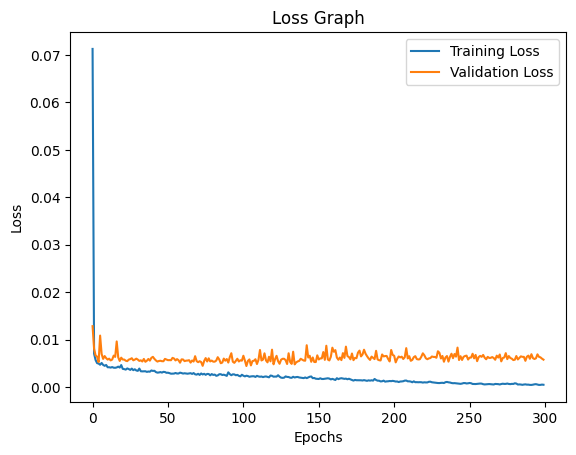

In [27]:
# Define the model parameters
input_size = 8
hidden_size = 256
num_layers = 1
output_size = 3
dataloader = train_loader
num_epochs = 300
learning_rate = 0.01

#Create the model
model = LSTM_pt(input_size, hidden_size, num_layers, output_size).to(device)
loss_graph, val_graph = train(model, dataloader, val_loader, num_epochs = num_epochs, learning_rate = learning_rate, device = device)

plt.plot(loss_graph)
plt.plot(val_graph)
plt.title("Loss Graph")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [28]:
# Saving the final model
import os

# Create the 'models' directory if it doesn't exist
os.makedirs('./final_models', exist_ok=True)
torch.save(model.state_dict(), './final_models/LSTM.pth')

In [29]:
# Load Model
import random

# Define the model parameters
input_size = 8
hidden_size = 256
num_layers = 1
output_size = 3
dataloader = train_loader
num_epochs = 300
learning_rate = 0.01

model = LSTM_pt(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load('./final_models/LSTM.pth'))
seed_value = random.randint(0, 10000)

Normalized output[0]: [[0.39277440309524536], [0.4812377393245697], [0.3351217210292816]]
Normalized target[0]: [[0.3564389944076538], [0.3173632323741913], [0.31634387373924255]]
Denormalized output[0]: [[96.32791900634766], [118.02355194091797], [82.1885986328125]]
Denormalized target[0]: [[87.41666412353516], [77.83333587646484], [77.58333587646484]]
--------------------------------------------------
Normalized output[0]: [[0.2908787727355957], [0.3899434506893158], [0.4777926802635193]]
Normalized target[0]: [[0.3978933095932007], [0.48555895686149597], [0.4475025534629822]]
Denormalized output[0]: [[71.33802032470703], [95.63362884521484], [117.17865753173828]]
Denormalized target[0]: [[97.58333587646484], [119.08333587646484], [109.75]]
--------------------------------------------------
Normalized output[0]: [[0.5477873682975769], [0.5920661091804504], [0.5907579660415649]]
Normalized target[0]: [[0.5953109264373779], [0.5953109264373779], [0.5953109264373779]]
Denormalized outpu

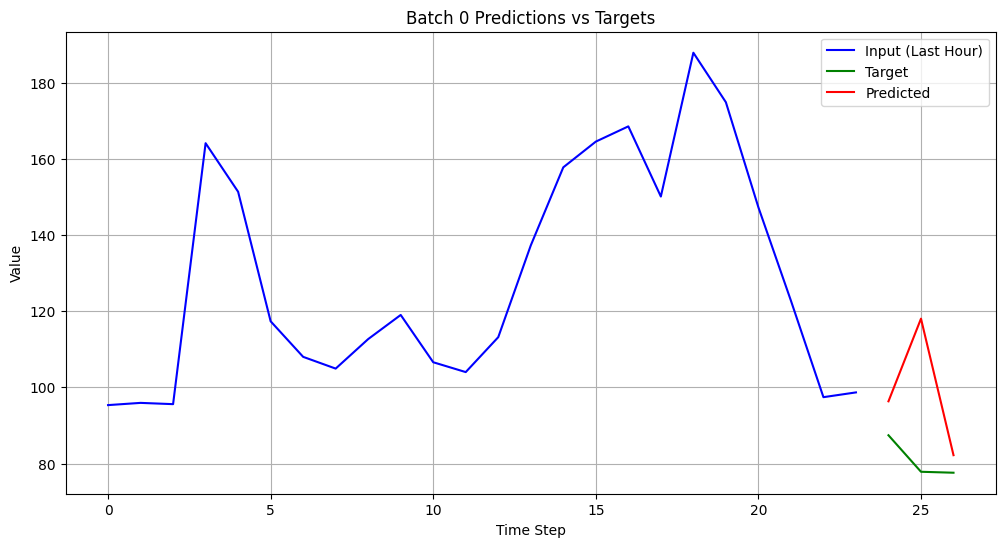

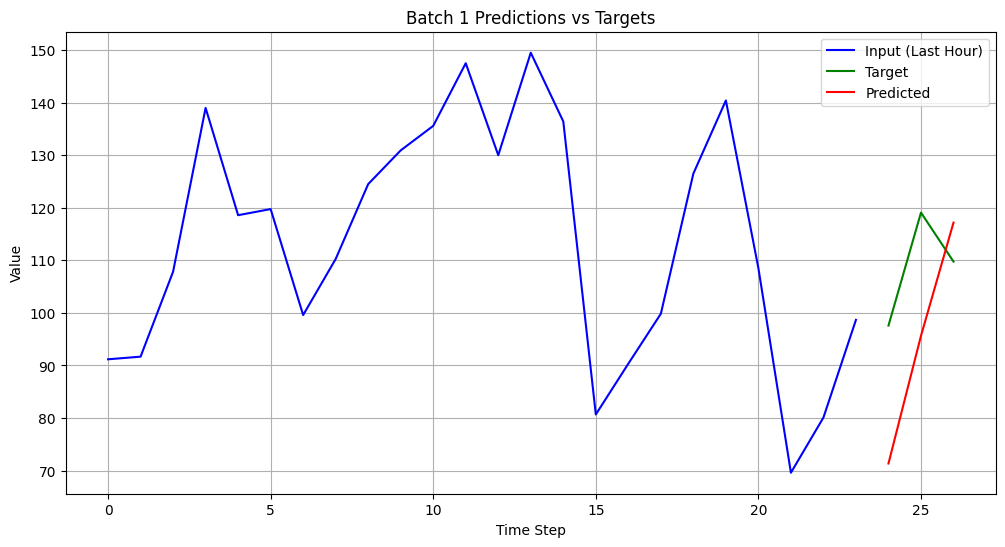

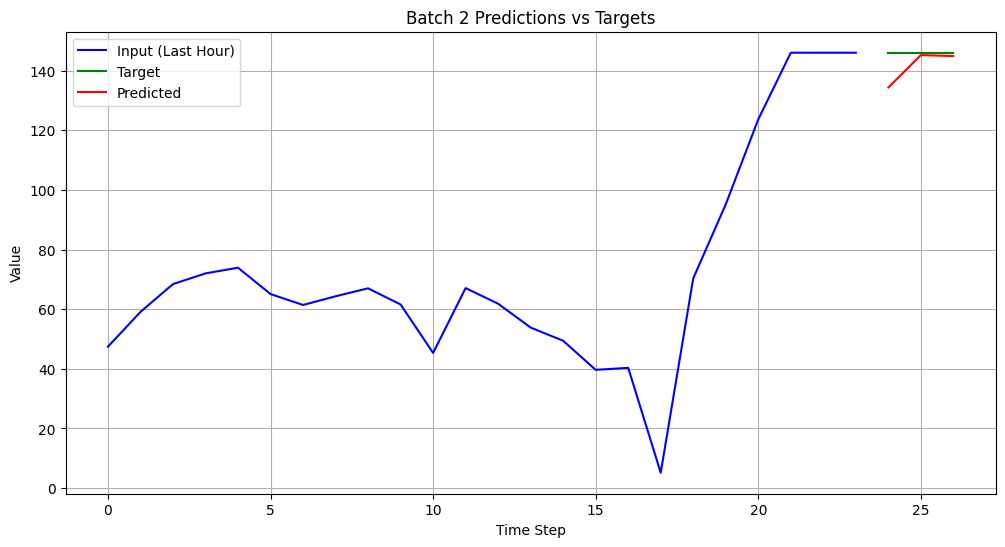

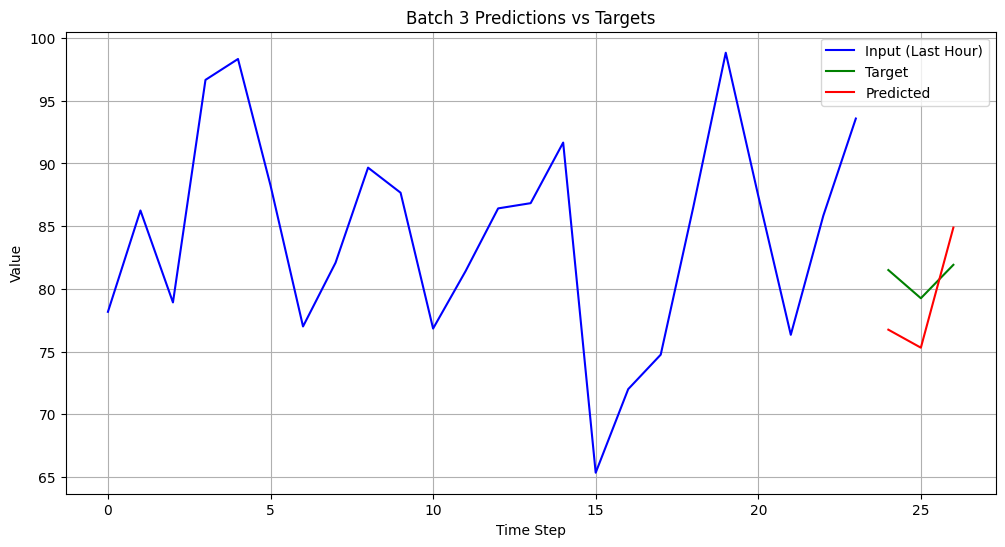

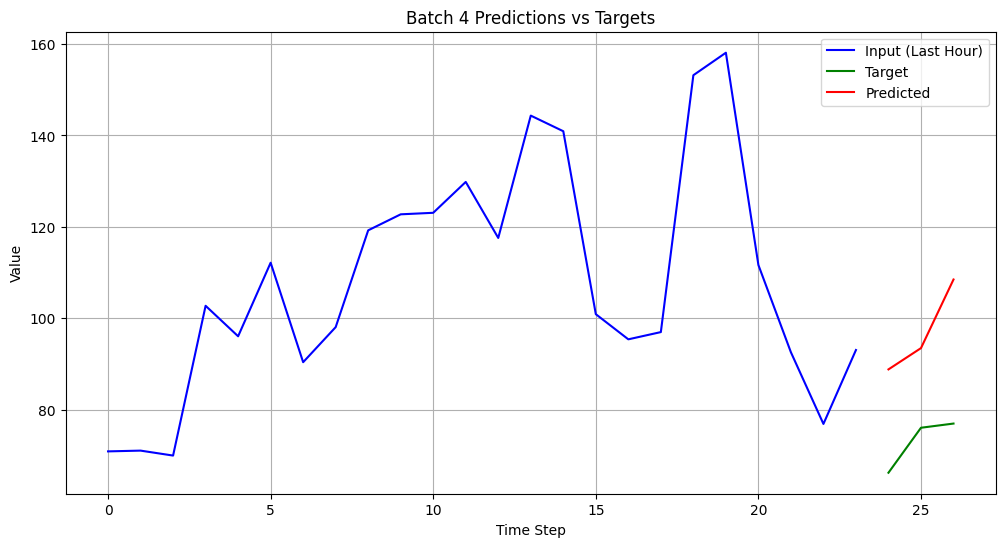

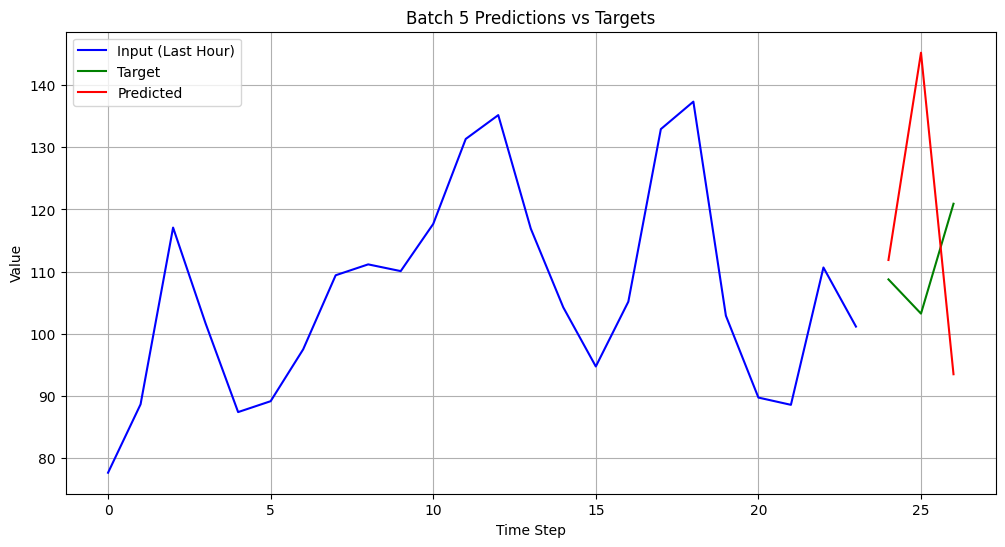

In [30]:
import collections
model.eval()

# Initialize variables to track loss
loss_value = 0
num_batches = 0

# Define the loss function
criterion = torch.nn.MSELoss()

# Initialize hidden state and cell state
hidden_state, cell_state = None, None  
mae_list = []
visualise_dataset = collections.defaultdict(list)

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
 
        # Forward pass
        inputs, cell_state, hidden_state = inputs.to(device), cell_state, hidden_state
        output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)
        output = output.unsqueeze(-1)

        output, targets = output.to(device), targets.to(device)

        # Denormalize predictions and targets (for all 3 time steps)
        inputs_denorm = inputs * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        output_denorm = output * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        targets_denorm = targets * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        
        visualise_dataset[batch_idx] = inputs_denorm[:,:, 5:6].cpu().numpy()
        # Add targets to visualise_dataset
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], targets_denorm.cpu().numpy()), axis=1)
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], output_denorm.cpu().numpy()), axis=1)

        # Compute loss on normalized data
        loss_value += criterion(output, targets)
        mae = torch.mean(torch.abs(output_denorm - targets_denorm))
        mae_list.append(mae)

        # Print a sample of the normalized and denormalized values
        print("Normalized output[0]:", output[0].tolist())  
        print("Normalized target[0]:", targets[0].tolist())  
        print("Denormalized output[0]:", output_denorm[0].tolist())  
        print("Denormalized target[0]:", targets_denorm[0].tolist())  
        print("-" * 50)

# Compute average loss
loss_value = loss_value / (len(test_loader) - 1)
print(f'Average Validation Loss: {loss_value:.4f}')

mae = torch.mean(torch.tensor(mae_list))
print(f'Mean Absolute Error: {mae:.4f}')

print(f'Average Validation Loss: {loss_value:.4f}')

# Visualize the predictions and targets for the first batch
for batch_idx, data in visualise_dataset.items():
    inputs = data[0, :24]       # First 25 timesteps
    targets = data[0, 24:27]    # 3 timesteps: ground truth
    predictions = data[0, 27:]  # 3 timesteps: model predictions
    plt.figure(figsize=(12, 6))
    # Input: plotted from timestep 0 to 24
    plt.plot(range(24), inputs[:, -1], label='Input (Last Hour)', color='blue')
    # Targets: plotted starting from timestep 24 to 26
    plt.plot(range(24, 27), targets[:, -1], label='Target', color='green')
    # Predictions: plotted from timestep 27 to 29
    plt.plot(range(24, 27), predictions[:, -1], label='Predicted', color='red')
    plt.title(f'Batch {batch_idx} Predictions vs Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()